# Multiples cadenas de Markov

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [64]:
def ln_likelihood(datos, parametros, teoria, desviacion_teoria, modelo):
    '''
    DESCRIPTION: Esta funcion regresa un valor proporcional al likelihood
    IN: datos = las x, variable independiente,
        parametros = parametros del modelo
        teoria = las y, variable dependiente,
        desviacion_teoria = desviacion de las y,
        modelo = funcion que aplica el modelo
    OUT: Numero flotante proporcional al liklihood de los parametros dados
    '''
    #Inicializamos la suma
    suma = 0
    
    #Sumamos cada elemento
    for i in range (len(datos)):
        suma += (teoria[i]-modelo(datos[i], parametros))**2/desviacion_teoria[i]**2
    return -(1/2)*suma


def montecarlo_mc(N, datos, teoria, desviacion_teoria, modelo, desviacion_parametros, p_old, n_pasos=500, seed = 500):
    '''
    REQUIREMENTS: Numpy
    DESCRIPTION: Esta funcion aplica el metodo de montecarlo para obtener los valores
                 mas probables de determinados parametros de un modelo aplicado a
                 ciertos datos conocidos.
    IN: N = numero de cadenas deseadas
        datos = las x, variable independiente,
        teoria = las y, variable dependiente,
        desviacion_teoria = desviacion de las y,
        modelo = funcion que aplica el modelo,
        desviacion_parametros = desviacion estandar conocidas para cada parametro,
        p_old = N aproximaciónes iniciales,
        n_pasos = numero de pasos,
        seed = semilla de numeros aleatorios
    OUT: cadena de markov con likelihoods asociados, y un valor booleano de si el parametro fue aceptado o no,
         esto en cada parametro de la cadena.
    '''
    #Creamos lista donde estarán las cadenas
    markov_matrix = []
    
    #Corremos N veces para obtener n cadenas
    for i_cadena in range(N):
        
        #Para tener datos reproducibles, damos un seed para los numeros aleatorios
        np.random.seed(seed)

        #Inicializamos la cadena de markov
        markov_chain = []

        #agregamos el primer conjunto de parametros y su likelihood
        l_old = ln_likelihood(datos, p_old[i_cadena], teoria, desviacion_teoria, modelo)
        markov_chain.append([p_old[i_cadena], l_old, True])

        #Realizamos n iteraciones
        for paso in range(n_pasos):

            #Lista para nuevo parametro
            p_new = []

            #Llenamos p_new con una distribución aleatoria normal
            for j, parametro in enumerate(p_old[i_cadena]):
                p_new.append(desviacion_parametros[j]*np.random.randn()+parametro)

            #Calculamos nuevo likelihood
            l_new = ln_likelihood(datos, p_new, teoria, desviacion_teoria, modelo)

            #Guardamos nuevo punto, su likelihood y si lo aceptamos o no segun las condiciones
            if (l_new>l_old):
                markov_chain.append([p_new, l_new, True])
                p_old[i_cadena] = p_new
                l_old = l_new
            elif  (np.exp(l_new)/np.exp(l_old) > np.random.randn()):
                markov_chain.append([p_new, l_new, True])
                p_old[i_cadena] = p_new
                l_old = l_new
            
            markov_chain.append([p_new, l_new, False])
  
        #Agregamos la cadena de esta iteración a la lista de cadenas
        markov_matrix.append(markov_chain)
            
    else:
        return markov_matrix

In [65]:
# Definimos el modelo que aplicamos, que es una recta
def recta(x, parametros):
    return x*parametros[0]+parametros[1]

#Parametros y sus desviaciones
p_reales = [10, 10]
des_p = [0.1, 0.1]

#Construimos la recta:
x = np.linspace(0, 10, 1000)
y = x*p_reales[0]+p_reales[1]
des_y = [0.1 for punto in range(len(y))]

#Establecemos los N parametros iniciales que usaremos
p_iniciales = [[5, 10],[7, 13], [15, 13], [15, 7], [7, 7]]

#Aplicamos el mcmc
cadenas = montecarlo_mc(N = 5, datos = x, desviacion_teoria = des_y, teoria = y, 
                       modelo = recta, desviacion_parametros = des_p, p_old = p_iniciales, n_pasos = 30000)

C:\Users\missa\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


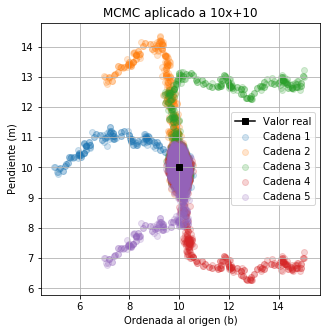

In [66]:
puntos = []
likely = []
accepted = []
x = []
y = []

best = np.zeros((5, 2))

for i, cadena in enumerate(cadenas):
    x.append([])
    y.append([])
    likely.append([])
    accepted.append([])
    for dato, like, accept in cadena:
        x[i].append(dato[0])
        y[i].append(dato[1])
        likely[i].append(like)
        accepted[i].append(accept)
        
        
fig, ax0 = fig, ax0 = plt.subplots(figsize=(5, 5))

for i in range(len(cadenas)):
    ax0.scatter(x[i], y[i], marker = 'o', label = 'Cadena '+str(i+1), alpha = 0.2)

plt.plot(p_reales[0], p_reales[1], marker = 's', label = 'Valor real', c = 'black')
ax0.set_ylabel('Pendiente (m)')
ax0.set_xlabel('Ordenada al origen (b)')
ax0.grid()
plt.legend()
plt.title(f'MCMC aplicado a {p_reales[0]}x+{p_reales[1]}')

plt.show()

In [67]:
#Obtenemos la fraccion de aceptacion de los parametros
ratio = np.zeros(5)
best = []
pruebas = len(cadenas[0])

for i in range(5):
    ratio[i] = sum(accepted[i])/pruebas
    index = likely[i].index(max(likely[i]))
    best.append([x[i][index], y[i][index]])
    
for i, num in enumerate(ratio):
    print(f'{i+1} Fraccion de aceptacion de la cadena {i}: {num:.3f}.', end = ' ')
    print(f'Mejor valor m = {best[i][0]:.4f} ; b = {best[i][1]:.4f}')
    
print(f'Reales m = {p_reales[0]} ; b = {p_reales[1]}')

1 Fraccion de aceptacion de la cadena 0: 0.187. Mejor valor m = 10.0010 ; b = 9.9954
2 Fraccion de aceptacion de la cadena 1: 0.191. Mejor valor m = 10.0007 ; b = 9.9970
3 Fraccion de aceptacion de la cadena 2: 0.187. Mejor valor m = 10.0002 ; b = 10.0020
4 Fraccion de aceptacion de la cadena 3: 0.196. Mejor valor m = 10.0002 ; b = 9.9972
5 Fraccion de aceptacion de la cadena 4: 0.194. Mejor valor m = 9.9992 ; b = 10.0026
Reales m = 10 ; b = 10


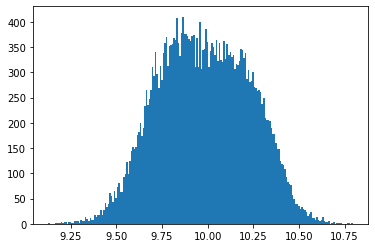

In [77]:
plt.hist(y[0][5000:], 200)
plt.show()

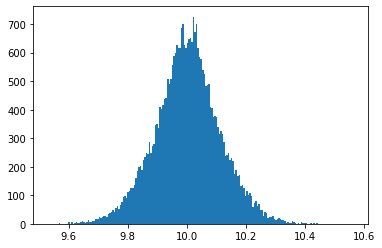

In [78]:
plt.hist(x[0][5000:], 200)
plt.show()

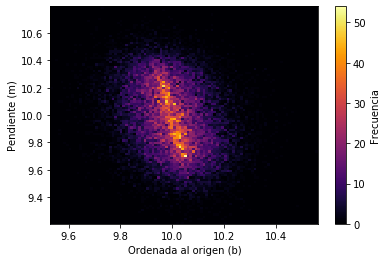

In [91]:
plt.hist2d(x[0][8000:],y[0][8000:], 100, cmap = 'inferno')
plt.ylabel('Pendiente (m)')
plt.xlabel('Ordenada al origen (b)')
plt.colorbar(label = 'Frecuencia')
plt.show()

Se busca que la **fracción de aceptación** este en el intervalo `[0.2, 0.5]`, esto expresa que fraccion e tus pasos en la cadena se estna aceptando. Si es muy pequeño, se esta avanzando con mucha dificultad (i.e no converge); en cambio si es muy alta, se esta recorriendo el espacio de parametros de manera casí uniforme.

Es recomendable corre **cadenas largas**, para obtener una mejor nube de probabilidad y asegurar convergencia, aunque en realidad el numero de pasos depende totalmente del tipo de problema que estemos atacando, por ejemplo, del numero de parametros y sus caracteristicas. Tambien es recomendable correr **varias cadenas**.

Despues de tener la cadena, es necesario cortar los pasos iniciales hasta que se llegue a la zona de alta probabilidad, lo que se denomina como **burning**. Para esto nos podemos apoyar de las graficas de valor vs. paso para cada uno de los parametros.

Existen varias condiciones cuantitativas para determianar si una cadena ha **convergido** o no. Un metodo cuantitativo para conocer si el metodo a convergido es el [diagnostico Gelman-Rubin](https://projecteuclid.org/download/pdf_1/euclid.ss/1177011136).

Si el codigo esta bien programado y las $\sigma$ estan elegidas bien, teoricamente las cadenas *siempre* convergen en un tiempo infinito.

Una vez que tenemos la cadena generada y una vez que retiramos el **burning**, para elegir que valor reportar, debemos tomar la media y tomar la desviacion estandar. Esto es idealmente, en caso de obtener una distribución gaussiana. En caso contrario, depende de que resultado obtengamos; esta 'decición'la podemos apoyar graficando todos los histrogramas 2d y 1d de todos los parametros para visualizar que decisiones serian optimas.

Por hacer:
1. Definir el prior
2. Utilizar funcion mcmc con prior en lugar de likelihood
3. Hacer funcion que grafique histogramas 2d junto con histogramas individuales (triangle plot) (Sugerencias de librerias: corner, getdist) esto se hace de las n cadenas juntas.
4. Hacer funcion que grafique valor vs paso para seleccionar corte de burning
5. Implementar Gelman-Rubin
6. Implementar pausa de tiempo